In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from sklearn.decomposition import PCA
import seaborn as sns
from collections import Counter
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import KFold
from collections import defaultdict


In [2]:
def draw_image(strokes, size=28):
    fig = Figure(figsize=(1, 1), dpi=size, facecolor='white')  # White background
    canvas = FigureCanvas(fig)
    ax = fig.add_axes([0, 0, 1, 1])  # No padding, fill full canvas

    for x, y in strokes:
        ax.plot(x, y, color='black', linewidth=3)  # Black strokes

    ax.set_xlim(0, 255)
    ax.set_ylim(0, 255)
    ax.axis('off')
    ax.invert_yaxis()  # Match image orientation (top down)

    canvas.draw()
    buf = canvas.buffer_rgba()
    image = np.asarray(buf)[:, :, :3]  # Drop alpha

    # Convert to grayscale (0–255 float)
    image = image.mean(axis=2)

    # Normalize to 0–1 (optional for ML)
    return image / 255.0

##### Define get_data function

In [3]:
def get_data(filepath, max_items):
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            if len(data) >= max_items:
                break
            item = json.loads(line)
            if item.get("recognized", False):
                data.append(item)
    return data

##### Define function for creating a dataset

In [4]:
def create_dataset(datasets_dict, samples_per_class=1000):
    X = []
    y = []
    
    for label, drawings in datasets_dict.items():
        for item in drawings[:samples_per_class]:
            img = draw_image(item["drawing"])
            X.append(img.flatten())  # Flatten 28x28 to 784
            y.append(label)
    
    return np.array(X), np.array(y)

##### Load the data

In [5]:
# Load data
#airplanes = get_data("quickdraw_data/airplane.ndjson", 2000)
houses = get_data("quickdraw_data/house.ndjson", 2000)
trees = get_data("quickdraw_data/tree.ndjson", 2000)
fishes = get_data("quickdraw_data/fish.ndjson", 2000)
clocks = get_data("quickdraw_data/clock.ndjson", 2000)
umbrellas = get_data("quickdraw_data/umbrella.ndjson", 2000)
#spoons = get_data("quickdraw_data/spoon.ndjson", 2000)
ladders = get_data("quickdraw_data/ladder.ndjson", 2000)
#lightnings = get_data("quickdraw_data/lightning.ndjson", 2000)

# Prepare dataset
datasets = {
    #"airplanes": airplanes,
    "houses": houses,
    "trees": trees,
    "fishes": fishes,
    "clocks": clocks,
    "umbrellas": umbrellas,
    #"spoons": spoons,
    "ladders": ladders,
    #"lightnings": lightnings,
}

X, y = create_dataset(datasets, samples_per_class=2000)

Visualize the data

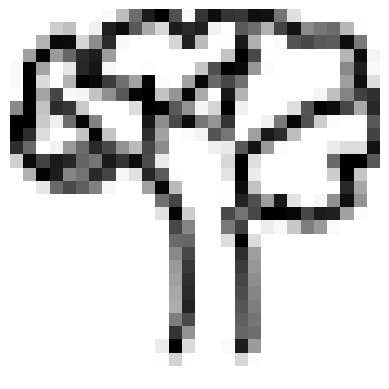

In [6]:
drawing = trees[10]["drawing"]
img = draw_image(drawing)

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

##### Normalize the data

In [7]:
# Normalize pixel values (optional but helpful for KNN)
def get_scaled_features(X):
    return pd.DataFrame(scaler.transform(X))  # do NOT fit again

# Reduce to 2D for plotting
def get_reduced_features(X):
    return pca.transform(X)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X)) 

pca = PCA(n_components=100)
X_reduced = pd.DataFrame(pca.fit_transform(X_scaled))

print(X_reduced.shape)

(12000, 100)


##### Create a scatterplot of the data

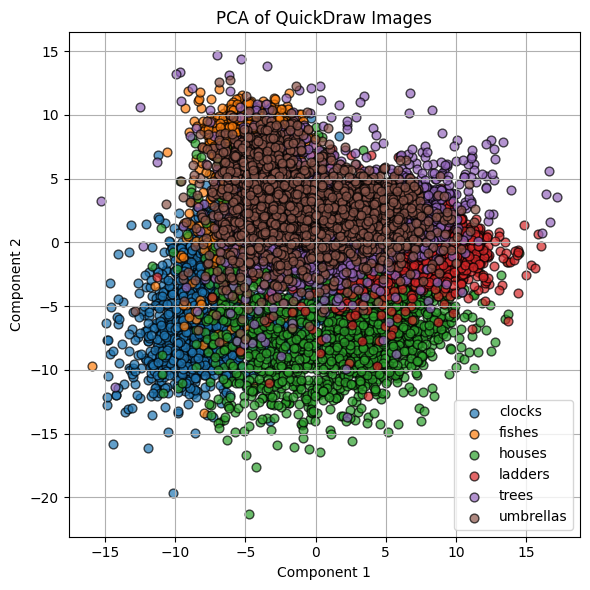

In [8]:
def plot_scatter(X, y, title='Scatter Plot', figsize=(6, 6)):
    plt.figure(figsize=figsize)

    labels = np.unique(y)
    for label in labels:
        idx = y == label
        plt.scatter(X[idx, 0], X[idx, 1], label=label, alpha=0.7, edgecolors='k', s=40)

    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_scatter(X_reduced.to_numpy(), y, title='PCA of QuickDraw Images')

##### Train test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

##### Define algorithms

In [10]:
def knn_predict_weighted_fast(X_train, y_train, test_point, k, epsilon=1e-5):
    # Convert to NumPy arrays if not already
    X_train_np = np.asarray(X_train)
    y_train_np = np.asarray(y_train)

    # Compute all Euclidean distances in one go
    dists = np.linalg.norm(X_train_np - test_point, axis=1)  # Fast!

    # Get indices of k nearest neighbors
    knn_indices = np.argsort(dists)[:k]

    # Weighted voting
    weights = defaultdict(float)
    for idx in knn_indices:
        label = y_train_np[idx]
        weight = 1 / (dists[idx] + epsilon)
        weights[label] += weight

    # Return label with highest total weight
    return max(weights.items(), key=lambda x: x[1])[0]

def knn_predict_weighted_fast_batch_batched(X_train, y_train, X_test, k, batch_size=100):
    predictions = []

    for start in range(0, len(X_test), batch_size):
        end = min(start + batch_size, len(X_test))
        X_batch = X_test[start:end]

        # (batch_size, n_train, n_features) - (1, n_train, n_features) = (batch_size, n_train, n_features)
        dists = np.sqrt(
            np.sum((X_batch[:, np.newaxis, :] - X_train[np.newaxis, :, :]) ** 2, axis=2)
        )

        knn_indices = np.argpartition(dists, kth=k, axis=1)[:, :k]

        for i in range(len(X_batch)):
            neighbor_idxs = knn_indices[i]
            neighbor_labels = y_train[neighbor_idxs]
            neighbor_dists = dists[i][neighbor_idxs]
            weights = 1 / (neighbor_dists + 1e-8)

            votes = defaultdict(float)
            for lbl, w in zip(neighbor_labels, weights):
                votes[lbl] += w

            pred = max(votes.items(), key=lambda x: x[1])[0]
            predictions.append(pred)

    return np.array(predictions)

##### Find optimal K

In [11]:
def find_optimal_k_custom_knn(X, y, k_range):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    X_np = X.values if hasattr(X, 'values') else X
    y_np = y.values if hasattr(y, 'values') else y

    for k in k_range:
        fold_accuracies = []
        for train_idx, val_idx in kf.split(X_np):
            X_train_fold, X_val_fold = X_np[train_idx], X_np[val_idx]
            y_train_fold, y_val_fold = y_np[train_idx], y_np[val_idx]

            y_pred = knn_predict_weighted_fast_batch_batched(X_train_fold, y_train_fold, X_val_fold, k, batch_size=200)
            accuracy = np.mean(y_pred == y_val_fold)
            fold_accuracies.append(accuracy)

        avg_acc = np.mean(fold_accuracies)
        cv_scores.append(avg_acc)
        print(f"k={k}, Cross-val Accuracy={avg_acc:.4f}")

    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, cv_scores, marker='o')
    plt.title("Custom Weighted k-NN Cross-Validation Accuracy vs k")
    plt.xlabel("Number of Neighbors: k")
    plt.ylabel("Cross-Validated Accuracy")
    plt.grid(True)
    plt.show()

    best_k = k_range[np.argmax(cv_scores)]
    print(f"Best k from cross-validation: {best_k}")
    return best_k
    
# Randomly sample 6000 examples for cross-validation
#sample_size = 6000
#sample_indices = np.random.choice(len(X_train), sample_size, replace=False)

X_sample = X_train#.iloc[sample_indices]
y_sample = y_train#.iloc[sample_indices]

# Then run the optimized cross-validation on that subset
best_k = 5#find_optimal_k_custom_knn(X_sample, y_sample, range(1, 10))

In [12]:
test_index = np.random.randint(low=0, high=len(X_test)-1)  # index of the test sample to predict

test_point = X_test.iloc[test_index].values
label = y_test[test_index]

prediction = knn_predict_weighted_fast(X_train, y_train, test_point, best_k)
print(f"Predicted label: {prediction}")
print(f"Actual label: {label}")

Predicted label: fishes
Actual label: fishes


In [13]:
y_pred_custom = knn_predict_weighted_fast_batch_batched(
    X_train.to_numpy(), y_train,
    X_test.to_numpy(), best_k
)

##### Visualize confusion matrix and other stats

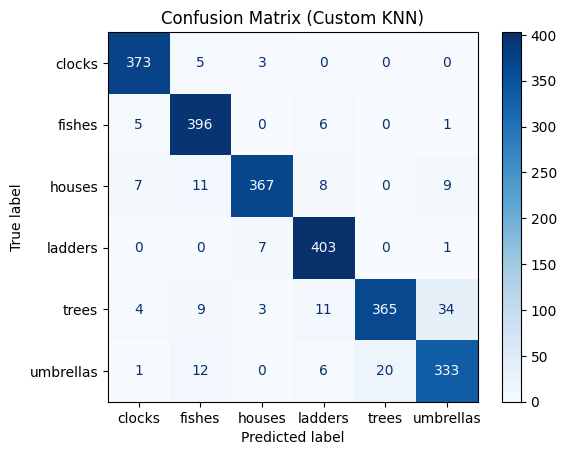

In [14]:
def display_confusion_matrix(y_test, y_pred_custom, labels, title):
    cm = confusion_matrix(y_test, y_pred_custom)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.grid(False)
    plt.show()

display_confusion_matrix(y_test, y_pred_custom, np.unique(y), 'Confusion Matrix (Custom KNN)')


In [15]:
print("Classification Report (Custom KNN):")
print(classification_report(y_test, y_pred_custom))

Classification Report (Custom KNN):
              precision    recall  f1-score   support

      clocks       0.96      0.98      0.97       381
      fishes       0.91      0.97      0.94       408
      houses       0.97      0.91      0.94       402
     ladders       0.93      0.98      0.95       411
       trees       0.95      0.86      0.90       426
   umbrellas       0.88      0.90      0.89       372

    accuracy                           0.93      2400
   macro avg       0.93      0.93      0.93      2400
weighted avg       0.93      0.93      0.93      2400



##### Demo of quick draw

In [16]:
import tkinter as tk
from PIL import Image, ImageDraw, ImageOps
import numpy as np

WIDTH, HEIGHT = 280, 280  # Drawing area size (bigger than 28x28 for precision)
DRAW_COLOR = 'white'
BG_COLOR = 'black'
LINE_WIDTH = 8

class SketchApp:
    def __init__(self):
        self.root = tk.Tk()
        self.root.title("Quick Draw Classifier")

        self.canvas = tk.Canvas(self.root, width=WIDTH, height=HEIGHT, bg=BG_COLOR)
        self.canvas.pack()

        self.image = Image.new("L", (WIDTH, HEIGHT), color=0)
        self.draw = ImageDraw.Draw(self.image)

        self.canvas.bind("<B1-Motion>", self.draw_on_canvas)

        # Buttons
        button_frame = tk.Frame(self.root)
        button_frame.pack()

        tk.Button(button_frame, text="Clear", command=self.clear_canvas).pack(side=tk.LEFT)
        tk.Button(button_frame, text="Predict", command=self.predict).pack(side=tk.LEFT)
        tk.Button(button_frame, text="Exit", command=self.root.quit).pack(side=tk.LEFT)

        self.result_label = tk.Label(self.root, text="", font=("Arial", 18))
        self.result_label.pack(pady=10)

    def draw_on_canvas(self, event):
        x, y = event.x, event.y
        r = LINE_WIDTH // 2
        self.canvas.create_oval(x - r, y - r, x + r, y + r, fill=DRAW_COLOR, outline=DRAW_COLOR)
        self.draw.ellipse((x - r, y - r, x + r, y + r), fill=255)

    def clear_canvas(self):
        self.canvas.delete("all")
        self.draw.rectangle((0, 0, WIDTH, HEIGHT), fill=0)
        self.result_label.config(text="")

    def preprocess_image(self):
        try:
            # Resize to 28x28 and invert (white drawing on black)
            img_resized = self.image.resize((28, 28), Image.LANCZOS)
            img_inverted = ImageOps.invert(img_resized)
    
            # Convert to numpy array and normalize to [0, 1]
            img_array = np.array(img_inverted) / 255.0
    
            # Optional: Scale to match original training format (0–16 or 0–1)
            img_flat = img_array.flatten().reshape(1, -1)  # shape: (1, 784)
    
            # Apply scaler and PCA (must be pre-fitted)
            scaled = scaler.transform(img_flat)           # shape: (1, 784)
            reduced = pca.transform(scaled)               # shape: (1, 100) if PCA(100)
    
            return reduced[0]  # return as 1D array
        except Exception as e:
            print(f"Error during preprocessing: {e}")
            return None


    def knn_predict(self, input_array):
        return knn_predict_weighted_fast(X_train, y_train, input_array, 5)

    def predict(self):
        input_array = self.preprocess_image()
        if input_array is None:
            self.result_label.config(text="Preprocessing failed.")
            return

        prediction = self.knn_predict(input_array)
        self.result_label.config(text=f"Prediction: {prediction}")

    def run(self):
        self.root.mainloop()


if __name__ == "__main__":
    app = SketchApp()
    app.run()
